In [1]:
import FinanceDataReader as fdr

start = '2008-01-01'
end = '2020-03-01'

SPY = fdr.DataReader("SPY", start=start, end=end)
VEU = fdr.DataReader("VEU", start=start, end=end)
AGG = fdr.DataReader("AGG", start=start, end=end)

In [2]:
import pandas as pd

close_data = pd.DataFrame({
                        'SPY':SPY['Close'],
                        'VEU':VEU['Close'],
                        'AGG':AGG['Close']}).dropna()

retmat = close_data.pct_change().dropna()

In [3]:
import numpy as np

def backtest(retmat, asset, init=0):
    change = retmat[asset]
    cumret = np.cumproduct(change+1, axis=0)
    port_ret = (init+1)*cumret-1
    res = pd.DataFrame(np.zeros(retmat.shape), 
                       columns=retmat.columns, 
                       index=retmat.index)
    res['momentum'] = port_ret
    res[asset] = 1
    return res


def momentum(data, date, rf):
    hist = data[:date-dt.timedelta(1)]
    h = hist.iloc[-1, :]
    if np.any(h[:2] > rf):
        return h[:2].idxmax()
    else:
        return h[-1:].idxmax()

In [4]:
import datetime as dt

dateobj_list = [dt.date(year, month, 1) for year in range(2008, 2021) for month in range(1, 13)]
datestr_list = [dt.datetime.strftime(date, '%Y-%m-%d') for date in dateobj_list]
dates = pd.Series(dateobj_list, index=datestr_list)

In [5]:
period = 120
rf = 0.0

momentum_data = close_data.pct_change(period).dropna()
start = dt.datetime.strftime(momentum_data.index[0]+dt.timedelta(31), '%Y-%m-%d')
res = []
r = None
for rebal_date in dates.loc[start:'2020-02-01']:
    i = dateobj_list.index(rebal_date)
    inv_until = dates.iloc[i+1]
    asset = momentum(momentum_data, rebal_date, rf)
    init = r.iloc[-1, -1] if r is not None else 0
    r = backtest(retmat[rebal_date:inv_until], asset, init)
    res.append(r)
res = pd.concat(res)

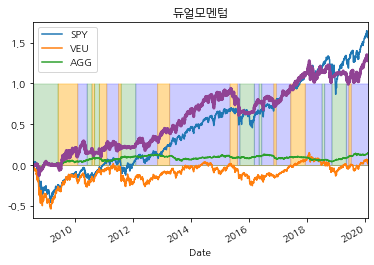

In [15]:
import matplotlib.pyplot as plt

compare = np.cumproduct(retmat.loc[start:'2020-02-01']+1)-1


compare.plot()
plt.plot(res['momentum'], color='#904394', linewidth=3)
plt.title("듀얼모멘텀")
plt.fill_between(res['SPY'].index, res['SPY'], alpha=0.2, color='b')
plt.fill_between(res['VEU'].index, res['VEU'], alpha=0.4, color='orange')
plt.fill_between(res['AGG'].index, res['AGG'], alpha=0.2, color='green')
plt.show()